# load code text

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CoDET-M4 dataset
dataset = load_dataset("DaniilOr/CoDET-M4")

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
python_dataset = dataset['train'].filter(lambda x: x['language'] == 'python')

/home/shenghua/anaconda3/envs/cpg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random

# Get unique models from the dataset (filtering out NoneType first)
# Some rows might have None for 'target', we want to ignore them or handle them.
all_models = [m for m in python_dataset['target'] if m is not None]
unique_models = sorted(list(set(all_models)))
print(f"Found {len(unique_models)} unique models: {unique_models}")

selected_indices = []

# Select 5 samples for each model
for model in unique_models:
    # We must ensure we match indices in the original python_dataset
    # enumerate(python_dataset['model']) gives global indices within python_dataset
    model_indices = [
        i for i, m in enumerate(python_dataset['target']) 
        if m == model
    ]
    
    # Sample 5, or all if less than 5
    count = min(5, len(model_indices))
    features = random.sample(model_indices, count)
    selected_indices.extend(features)

# Shuffle the combined indices
random.shuffle(selected_indices)

sample_code = python_dataset.select(selected_indices)

print(f"Total samples selected: {len(sample_code)}")
sample_code

Found 2 unique models: ['ai', 'human']
Total samples selected: 10


Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__'],
    num_rows: 10
})

In [3]:
# text to ast

In [4]:
import ast

# Initialize lists
valid_indices = []
sample_asts = []

print(f"Original sample size: {len(sample_code)}")
print("Converting sample_code to AST and filtering...")

for idx, example in enumerate(sample_code):
    try:
        # Parse the code content
        tree = ast.parse(example['code'])
        # If successful, keep track
        sample_asts.append(tree)
        valid_indices.append(idx)
    except SyntaxError as e:
        print(f"Skipping example {idx} due to SyntaxError: {e}")
    except Exception as e:
        print(f"Skipping example {idx} due to Error: {e}")

# Filter the dataset to keep only valid examples
if len(valid_indices) < len(sample_code):
    print(f"Filtering out {len(sample_code) - len(valid_indices)} invalid examples.")
    # Assuming sample_code is a HF Dataset, .select() creates a subset
    sample_code = sample_code.select(valid_indices)
else:
    print("All examples are valid.")

print(f"Conversion complete. Retained {len(sample_code)} valid examples and AST objects.")

# Show structure of the first AST as a verification
if sample_asts:
    print(f"\nExample AST structure (Item 0):")
    print(ast.dump(sample_asts[0], indent=2))

Original sample size: 10
Converting sample_code to AST and filtering...
All examples are valid.
Conversion complete. Retained 10 valid examples and AST objects.

Example AST structure (Item 0):
Module(
  body=[
    Import(
      names=[
        alias(name='pandas', asname='pd')]),
    Assign(
      targets=[
        Name(id='df', ctx=Store())],
      value=Call(
        func=Attribute(
          value=Name(id='pd', ctx=Load()),
          attr='read_csv',
          ctx=Load()),
        args=[
          Constant(value='AAPL.csv')],
        keywords=[])),
    Assign(
      targets=[
        Name(id='df', ctx=Store())],
      value=Subscript(
        value=Name(id='df', ctx=Load()),
        slice=BinOp(
          left=Compare(
            left=Subscript(
              value=Name(id='df', ctx=Load()),
              slice=Constant(value='Date'),
              ctx=Load()),
            ops=[
              GtE()],
            comparators=[
              Constant(value='2021-06-01')]),
         

# ast to pyg

In [5]:
import torch
from torch_geometric.data import Data
import ast

def ast_to_pyg_data(code_str, target_label):
    """
    Convert python code string to PyG Data object via AST.
    """
    try:
        tree = ast.parse(code_str)
    except SyntaxError:
        return None

    node_list = []
    edge_index = [[], []] # [source_nodes, target_nodes]
    edge_attr = [] # Edge text (field name)
    
    # Map node object id to index
    node_to_idx = {}

    def visit(node, parent_idx=None, relation=None):
        nonlocal node_list, edge_index, edge_attr
        
        # Current node index
        curr_idx = len(node_list)
        node_to_idx[id(node)] = curr_idx
        
        # Node features
        node_type = type(node).__name__
        
        node_list.append({
            'type': node_type
        })
        
        # Add edge if parent exists
        if parent_idx is not None:
            edge_index[0].append(parent_idx)
            edge_index[1].append(curr_idx)
            edge_attr.append(relation if relation else "child")
            
        # Traverse children
        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, ast.AST):
                        visit(item, curr_idx, field)
            elif isinstance(value, ast.AST):
                visit(value, curr_idx, field)

    visit(tree)

    if not node_list:
        return None
        
    # Convert to PyG Data
    
    data = Data(
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        num_nodes=len(node_list),
        node_texts=[n['type'] for n in node_list],
        edge_texts=edge_attr,
        code=code_str,
        y=target_label
    )
    
    return data

# Convert the sample_code dataset
pyg_dataset = []

print("Converting to PyG Data objects...")
for idx, item in enumerate(sample_code):
    data = ast_to_pyg_data(item['code'], item['target'])
    if data:
        pyg_dataset.append(data)
    else:
        print(f"Skipping item {idx} due to parse error or empty graph.")

print(f"Conversion complete. Created {len(pyg_dataset)} PyG Data objects.")

Converting to PyG Data objects...
Conversion complete. Created 10 PyG Data objects.


# adding features by text encoder

In [6]:
from create_feature import encode_text_graph

# Apply the encoding
# Using 'tiny' model (MiniLM) for efficiency in this demo
try:
    pyg_dataset = encode_text_graph(pyg_dataset, lm_type="tiny")
    
    # Verify the first graph
    if len(pyg_dataset) > 0:
        g = pyg_dataset[0]
        print("\nFeature Generation Complete.")
        print(f"Node Embeddings (x): {g.x.shape if hasattr(g, 'x') and g.x is not None else 'None'}")
        print(f"Edge Embeddings (edge_attr): {g.edge_attr.shape if hasattr(g, 'edge_attr') and g.edge_attr is not None else 'None'}")
except NameError:
    print("Error: pyg_dataset is not defined. Please run the previous cells first.")
except Exception as e:
    print(f"An error occurred during encoding: {e}")

Using device: cuda
Loading model: sentence-transformers/all-MiniLM-L6-v2
Encoding features for 10 graphs...


100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Feature Generation Complete.
Node Embeddings (x): torch.Size([260, 384])
Edge Embeddings (edge_attr): torch.Size([259, 384])


# pretrain

In [ ]:
import importlib
import CodeCLIP
importlib.reload(CodeCLIP)
from CodeCLIP import Pretrain

In [12]:
import torch
from torch_geometric.loader import DataLoader
from transformers import AutoTokenizer
from CodeCLIP import Pretrain
import torch.optim as optim
import os

# Create checkpoint directory
checkpoint_dir = 'checkpoints/CodeClip2'
os.makedirs(checkpoint_dir, exist_ok=True)
print(f"Checkpoints will be saved to: {checkpoint_dir}")

# Since our dataset is small (9 items), 128 is larger than the dataset.
batch_size = 128
# Create a DataLoader
loader = DataLoader(pyg_dataset, batch_size=batch_size, shuffle=True)

# Initialize Tokenizer
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
vocab_size = tokenizer.vocab_size

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = Pretrain(graph_in_dim=384, text_vocab_size=vocab_size, embed_dim=256).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- Resume from Checkpoint if exists ---
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint.pt')
if os.path.exists(checkpoint_path):
    print(f"Found checkpoint at {checkpoint_path}. Loading...")
    model.load_state_dict(torch.load(checkpoint_path))
    print("Checkpoint loaded successfully.")
else:
    print("No checkpoint found. Starting training from scratch.")
# ----------------------------------------

# Dummy training loop
num_epochs = 100

print("Starting training...")
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    # loader yields batches of PyG Data objects
    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        # Tokenize on the fly
        text_inputs = tokenizer(
            data.code, 
            padding=True, 
            truncation=True, 
            max_length=512, 
            return_tensors='pt'
        ).input_ids.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits_graph, logits_text = model(data, text_inputs)
        
        # Loss
        loss = model.loss(logits_graph, logits_text)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    # Save checkpoint at the end of each epoch
checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint.pt')
torch.save(model.state_dict(), checkpoint_path)

print(f"Training finished. Last model saved to {checkpoint_path}")

Checkpoints will be saved to: checkpoints/CodeClip2
Using device: cuda
No checkpoint found. Starting training from scratch.
Starting training...
Epoch 1/100, Loss: 2.3027
Epoch 2/100, Loss: 2.2922
Epoch 3/100, Loss: 2.2844
Epoch 4/100, Loss: 2.2663
Epoch 5/100, Loss: 2.2049
Epoch 6/100, Loss: 2.1562
Epoch 7/100, Loss: 2.0685
Epoch 8/100, Loss: 1.9214
Epoch 9/100, Loss: 1.8710
Epoch 10/100, Loss: 1.9995
Epoch 11/100, Loss: 1.7616
Epoch 12/100, Loss: 1.8599
Epoch 13/100, Loss: 1.7173
Epoch 14/100, Loss: 1.7023
Epoch 15/100, Loss: 1.6905
Epoch 16/100, Loss: 1.6114
Epoch 17/100, Loss: 1.6078
Epoch 18/100, Loss: 1.6147
Epoch 19/100, Loss: 1.5833
Epoch 20/100, Loss: 1.5622
Epoch 21/100, Loss: 1.5554
Epoch 22/100, Loss: 1.5492
Epoch 23/100, Loss: 1.5372
Epoch 24/100, Loss: 1.5275
Epoch 25/100, Loss: 1.5166
Epoch 26/100, Loss: 1.5101
Epoch 27/100, Loss: 1.5038
Epoch 28/100, Loss: 1.5045
Epoch 29/100, Loss: 1.5047
Epoch 30/100, Loss: 1.4988
Epoch 31/100, Loss: 1.4948
Epoch 32/100, Loss: 1.4924


In [13]:
# Load the model from checkpoint and extract graph embeddings
model.eval()

# Load state dict
# checkpoint_path was defined in the previous cell ('checkpoints/CodeClip/checkpoint.pt')
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
else:
    print(f"Checkpoint {checkpoint_path} not found. Using current model state.")

graph_embeddings = []
model.to(device)

print("Extracting graph embeddings...")
with torch.no_grad():
    for batch_idx, data in enumerate(loader):
        data = data.to(device)
        features = model.graph_encoder(data.x, data.edge_index, data.edge_attr, data.batch)
        
        # Normalize if needed (CodeCLIP does it in forward, so we probably should too for consistency)
        features = features / features.norm(dim=1, keepdim=True)
        
        graph_embeddings.append(features.cpu())

# Concatenate all embeddings
if graph_embeddings:
    all_graph_embeddings = torch.cat(graph_embeddings, dim=0)
else:
    print("No embeddings extracted.")

Loading checkpoint from checkpoints/CodeClip2/checkpoint.pt
Extracting graph embeddings...


/tmp/ipykernel_762805/2112133876.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


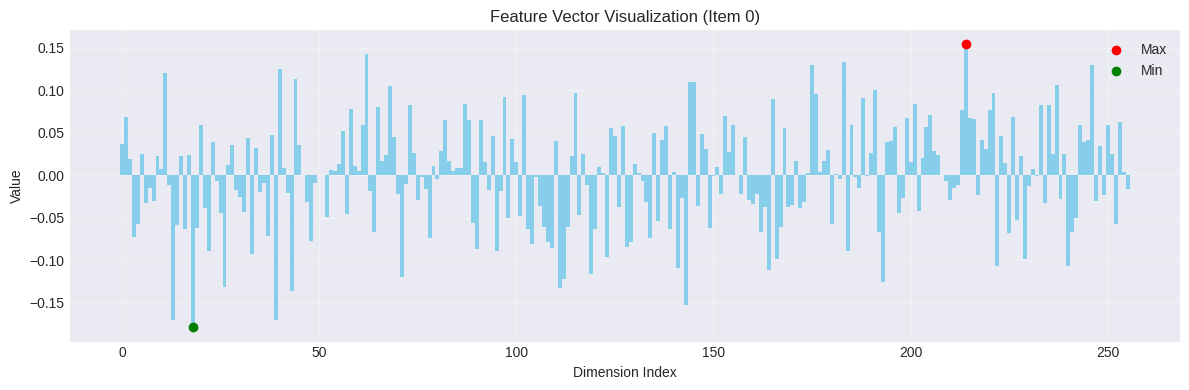

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Select the first embedding
embedding_vector = all_graph_embeddings[0, :].numpy()

# Create a bar plot
plt.figure(figsize=(12, 4))
plt.bar(range(len(embedding_vector)), embedding_vector, color='skyblue', width=1.0)
plt.title('Feature Vector Visualization (Item 0)')
plt.xlabel('Dimension Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)

# Highlight max and min
max_idx = np.argmax(embedding_vector)
min_idx = np.argmin(embedding_vector)
plt.scatter([max_idx], [embedding_vector[max_idx]], color='red', label='Max', zorder=5)
plt.scatter([min_idx], [embedding_vector[min_idx]], color='green', label='Min', zorder=5)

plt.legend()
plt.tight_layout()
plt.show()

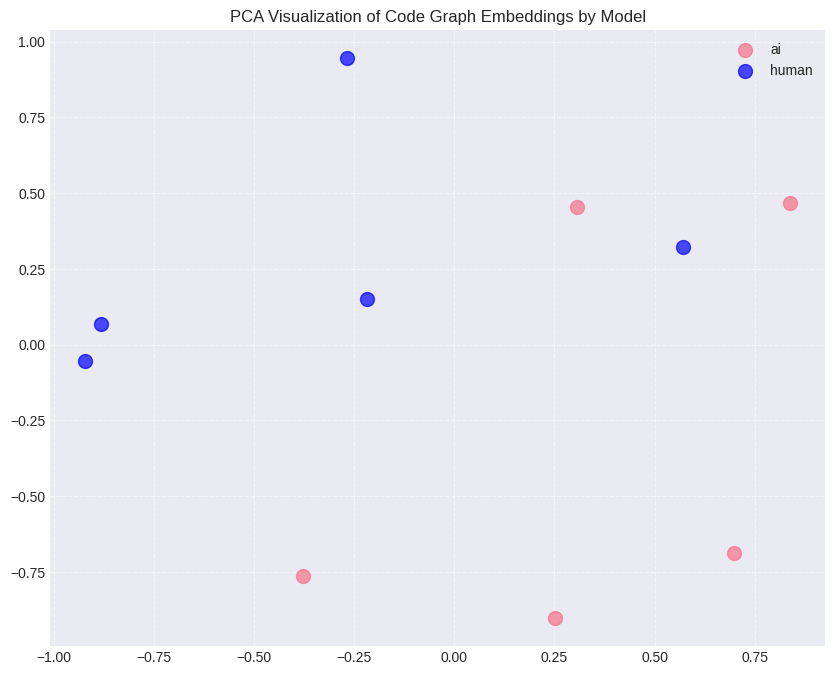

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

embeddings = all_graph_embeddings.detach().cpu().numpy()
labels = [data.y for data in pyg_dataset]

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
label_set = list(set(labels))

# Defines a more comprehensive color map
color_map = {
    'human': 'blue', 
    'gpt': 'red',
    'llama3.1': 'orange',
    'codellama': 'green',
    'qwen1.5': 'purple',
    'nxcode': 'cyan'
} 
# Fallback for unknown labels (using a palette)
fallback_colors = sns.color_palette("husl", len(label_set))

for i, label in enumerate(label_set):
    indices = [j for j, l in enumerate(labels) if l == label]
    if not indices: continue
    
    points = embeddings_2d[indices]
    
    # Use color_map if label exists, otherwise use fallback
    color = color_map.get(label, fallback_colors[i])
    
    plt.scatter(points[:, 0], points[:, 1], 
                c=[color], 
                label=label, alpha=0.7, s=100)

plt.title('PCA Visualization of Code Graph Embeddings by Model')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

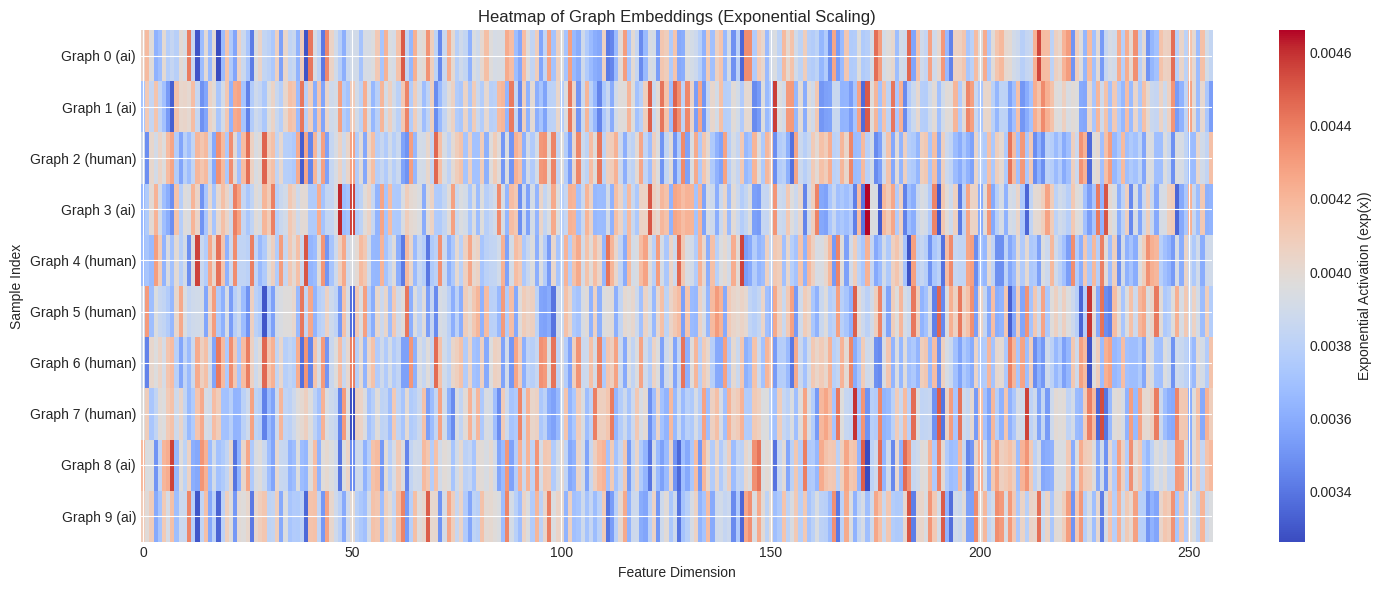

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get embeddings
embeddings = all_graph_embeddings.detach().cpu().numpy()

# 2. Apply Exponential Transformation
embeddings_exp = np.exp(embeddings) 

embeddings_exp = np.exp(embeddings) / np.sum(np.exp(embeddings), axis=1, keepdims=True)

plt.figure(figsize=(15, 6))

# 3. Plot
img = plt.imshow(embeddings_exp, cmap='coolwarm', aspect='auto', interpolation='nearest')

plt.colorbar(img, label='Exponential Activation (exp(x))')
plt.title('Heatmap of Graph Embeddings (Exponential Scaling)')
plt.xlabel('Feature Dimension')
plt.ylabel('Sample Index')

plt.yticks(range(len(embeddings)), labels=[f"Graph {i} ({l})" for i, l in enumerate(labels)])

plt.tight_layout()
plt.show()

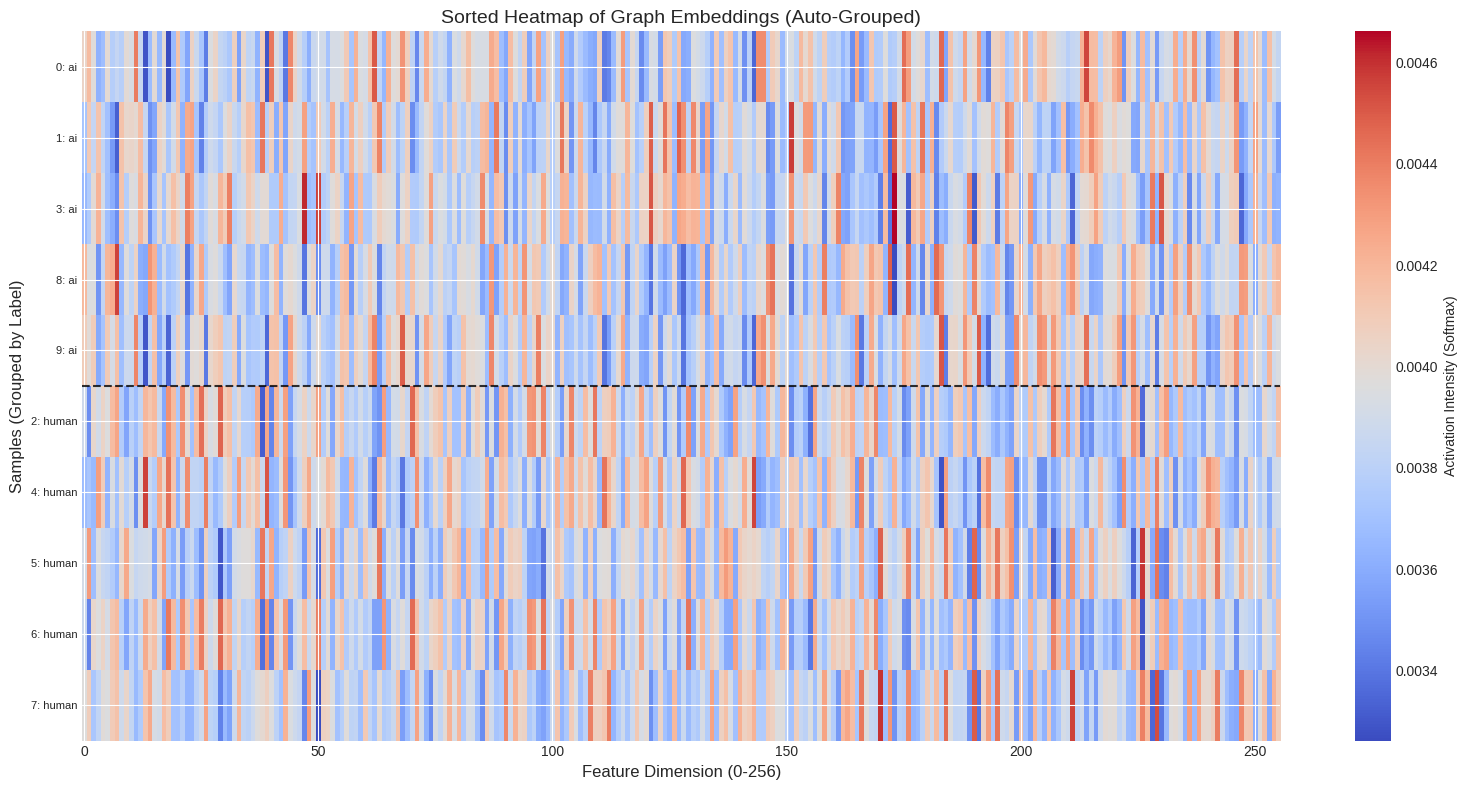

In [17]:
import matplotlib.pyplot as plt
import numpy as np

embeddings_np = all_graph_embeddings.detach().cpu().numpy()
labels_list = [data.y for data in pyg_dataset]

sorted_indices = np.argsort(labels_list)
sorted_embeddings = embeddings_np[sorted_indices]
sorted_labels = np.array(labels_list)[sorted_indices]

exp_vals = np.exp(sorted_embeddings - np.max(sorted_embeddings, axis=1, keepdims=True))
embeddings_processed = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

plt.figure(figsize=(16, 8))

img = plt.imshow(embeddings_processed, cmap='coolwarm', aspect='auto', interpolation='nearest')

for i in range(1, len(sorted_labels)):
    if sorted_labels[i] != sorted_labels[i-1]:
        plt.axhline(y=i-0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.8)

plt.colorbar(img, label='Activation Intensity (Softmax)')
plt.title('Sorted Heatmap of Graph Embeddings (Auto-Grouped)', fontsize=14)
plt.xlabel('Feature Dimension (0-256)', fontsize=12)
plt.ylabel('Samples (Grouped by Label)', fontsize=12)

plt.yticks(
    ticks=range(len(sorted_labels)), 
    labels=[f"{i}: {lbl}" for i, lbl in zip(sorted_indices, sorted_labels)],
    fontsize=8
)

plt.tight_layout()
plt.show()

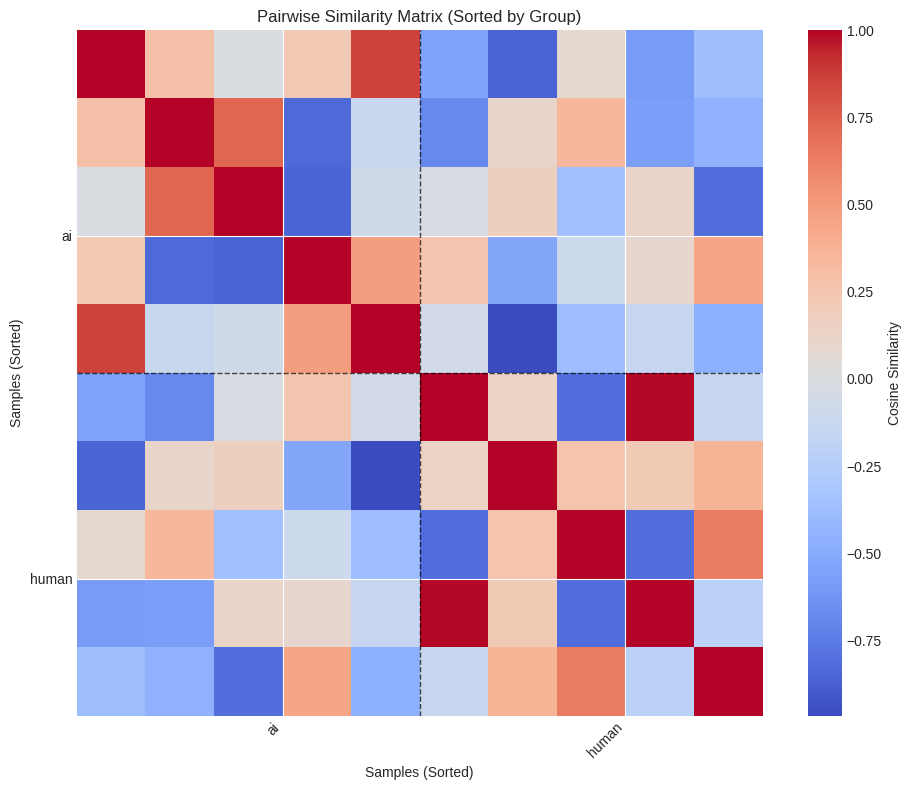

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Re-calculate sorted embeddings to ensure context (using variables from previous steps)
embeddings_np = all_graph_embeddings.detach().cpu().numpy()
labels_list = [data.y for data in pyg_dataset]

sorted_indices = np.argsort(labels_list)
sorted_embeddings = embeddings_np[sorted_indices]
sorted_labels = np.array(labels_list)[sorted_indices]

# Compute Cosine Similarity Matrix
# Normalize vectors to unit length
norms = np.linalg.norm(sorted_embeddings, axis=1, keepdims=True)
normalized_embeddings = sorted_embeddings / (norms + 1e-8)  # Avoid div by zero

# Compute dot product (NxN similarity matrix)
similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

# Plot Heatmap
plt.figure(figsize=(10, 8))
# 'viridis' or 'coolwarm' are good choices. 'RdBu_r' is also good for -1 to 1 correlation.
# Since we deal with embeddings, values are likely > 0 if using ReLU, but cosine is -1 to 1.
# Let's use 'viridis' for general similarity or 'Blues'.
img = plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(img, label='Cosine Similarity')

# Draw separation lines for groups
transitions = [i for i in range(1, len(sorted_labels)) if sorted_labels[i] != sorted_labels[i-1]]
for t in transitions:
    plt.axhline(y=t-0.5, color='blacK', linestyle='--', linewidth=1, alpha=0.7)
    plt.axvline(x=t-0.5, color='blacK', linestyle='--', linewidth=1, alpha=0.7)

plt.title('Pairwise Similarity Matrix (Sorted by Group)')
plt.xlabel('Samples (Sorted)')
plt.ylabel('Samples (Sorted)')

# Optional: Add group labels on axes
# Calculate center positions for labels
group_starts = [0] + transitions + [len(sorted_labels)]
tick_locs = []
group_names = []
for i in range(len(group_starts)-1):
    start = group_starts[i]
    end = group_starts[i+1]
    tick_locs.append((start + end) / 2)
    group_names.append(sorted_labels[start])

plt.xticks(tick_locs, group_names, rotation=45, ha='right')
plt.yticks(tick_locs, group_names)

plt.tight_layout()
plt.show()